###**Problem**:



1.   In this homework, you are asked to classify plants based on dataset you have. Plants are divided into two categories according to their state of health:{healthy, unhealthy}. It is a binary classification problem, so the goal is to predict the correct class label in {0, 1}.

2.   Note: This notebook has been created in [Google Colab](https://colab.research.google.com/notebooks/). So, you should run it there. For other environmetns, you need to install used packages

3. Download datasets and notebooks from this link:
https://drive.google.com/drive/folders/1CzLGEZA7S0WhyVMTMUM-j4J6ptd6WyOx?usp=sharing.

4. For this notebook, the name of dataset is public_data.zip not clean_plant_dataset.npz




### 1-Mount Google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 1-1 Unzip dataset

In [ ]:
# Here, "/content/drive/MyDrive/Projects/1st A2NDL Project/Dataset/public_data.zip" is the address of dataset in my drive. You must replace it with yours
!unzip -qq "/content/drive/MyDrive/Projects/1st A2NDL Project/Dataset/public_data.zip" -d "/content"

### 2-Import Libraries

In [ ]:
import os, warnings,logging,cv2
from skimage.color import rgb2lab, deltaE_cie76
import numpy as np
import tensorflow as tf
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

### 3-Fix randomness and hide warnings

In [ ]:
seed = 42
#####
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'
#####
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
#####

### 4-Set first parameters of tensorflow

In [ ]:
# Import tensorflow
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print("tensorflow_version is :",tf.__version__)

tensorflow_version is : 2.14.0


### 5-Load dataset

In [ ]:
dataset = np.load("/content/public_data.npz", allow_pickle=True)

### 6-EDA

###6-1 First info of Data

In [ ]:
print("Our dataset includes a collection of pixels of plants, categorizing into 'healthy' and 'unhealthy'.")
print('*'*100)
# Watch keys available in the numpy array
keys = list(dataset.keys())
print('keys in our dataset are: ', keys)
print('*'*100)

# look at data shape
x = dataset["data"]
no_images = x.shape[0]
size_images = x.shape[1:3]
print('Dataset.data shape: ',x.shape)
print('*'*100)

# Look at labels
y = dataset["labels"]
no_labels = y.shape[0]
print("Dataset.labels list is : ",y)


# Look at bing balanced or imbalanced
_, counts = np.unique(y,return_counts=True) # count occurrence of each item
no_healthy_images = counts[0]
no_unhealthy_images = counts[1]
print("\n\n")
print("*"*70,end=" ")
print("Information Table ",end='*'*70)
# pass variables to a dictionary to be used as dataframe for a better show
info_table_dict = {"number_of_all_images":no_images, "image_width": size_images[0],"image_length": size_images[1], "number_of__labels":no_labels,
                   "number_of__healthy_images":no_healthy_images,"percentage%":no_healthy_images*100/no_labels,
                   "number_of__unhealthy_images":no_unhealthy_images,"percentage %":no_unhealthy_images*100/no_labels }
info_table = pd.DataFrame(info_table_dict, index =['value'])
info_table

Our dataset includes a collection of pixels of plants, categorizing into 'healthy' and 'unhealthy'.
****************************************************************************************************
keys in our dataset are:  ['data', 'labels']
****************************************************************************************************
Dataset.data shape:  (5200, 96, 96, 3)
****************************************************************************************************
Dataset.labels list is :  ['healthy' 'healthy' 'healthy' ... 'healthy' 'healthy' 'healthy']



********************************************************************** Information Table **********************************************************************

,number_of_all_images,image_width,image_length,number_of__labels,number_of__healthy_images,percentage%,number_of__unhealthy_images,percentage %
value,5200,96,96,5200,3199,61.519231,2001,38.480769


####6-2 Data distribution

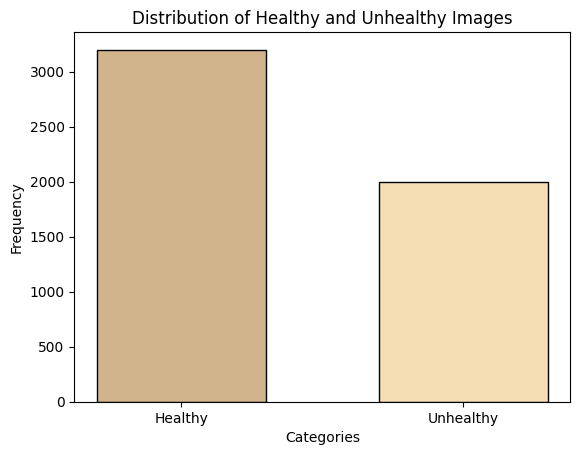

In [ ]:
# Show histogram of y(labels) to investigate wheather dataset is balanced or not
plt.bar([0, 1], [y[np.where(y=="healthy")].shape[0], y[np.where(y=="unhealthy")].shape[0] ], color=['#d2b48c', '#f5deb3'], edgecolor='black',width = 0.6)

# Add labels and title
plt.xlabel('Categories')
plt.ylabel('Frequency')
plt.title('Distribution of Healthy and Unhealthy Images')

# Add x-axis ticks and labels
plt.xticks([0, 1], ['Healthy', 'Unhealthy'])

# Show the plot
plt.show()

#### 6-3 Label Encode

In [ ]:
# Turn healty and unhealthy labels to two classes of 0 and 1, using labelEncoder
labels_before_encoder = y

# Create a LabelEncoder
label_encoder = preprocessing.LabelEncoder()

# Fit and transform the encoder on the original array
labels_after_encoder = label_encoder.fit_transform(y)

# set y  to new values
y = labels_after_encoder


print(f"before label encoding, list is like this :{labels_before_encoder}. And, unique items are: {np.unique(labels_before_encoder)}")
print(f"after label encoding, list is like this :{labels_after_encoder}. And, unique items are: {np.unique(labels_after_encoder)}")

before label encoding, list is like this :['healthy' 'healthy' 'healthy' ... 'healthy' 'healthy' 'healthy']. And, unique items are: ['healthy' 'unhealthy']
after label encoding, list is like this :[0 0 0 ... 0 0 0]. And, unique items are: [0 1]


#### 6_4 Show images

In [ ]:

# A function for displaying images in batches
def show_images(dataset, labels, batch_no, no_images_per_batch, num_cols=10):
    '''input: dataset wiht shape(None,width,lenght,channel),
              labels with this format [1 0 1 0 1 1 ... 1]],
              batch_no says which section/batch of your data you want to show,
              no_images_per_batch says how many images you want to put into one batch

       output: show images you want'''


    start_index = batch_no * no_images_per_batch
    end_index = min((batch_no + 1) * no_images_per_batch, len(dataset))
    num_rows = (end_index - start_index + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols)


    for i, ax in enumerate(axes.ravel()):
        if start_index + i < end_index:
            image = dataset[start_index + i]
            image = image / 255.0  # Normalize pixel values to [0, 1]
            ax.imshow(image)
            ax.set_title(f"{labels[start_index + i]}",fontsize=10, y=-0.5)
            ax.axis('off')

    for i in range(end_index - start_index, num_rows * num_cols):
        fig.delaxes(axes.flatten()[i])

    plt.show()


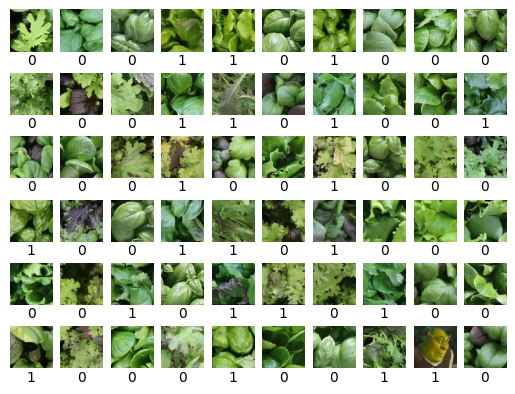

In [ ]:
show_images(dataset=x,labels =y, batch_no=0,no_images_per_batch=60)
print("You can see Sherek image is a kind of outliers, So we need to remove it and similar iamges from our dataset")

#### 6-5 Remove Outliers

In [ ]:
# As you understood there are some uselees images in dataset which must be first
# recognized and then remoeved. Let's do it together

def histogram_similarity(image, reference_histogram, threshold=0.8):

    # Calculate the color histogram of the image
    image_histogram = cv2.calcHist([image], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    cv2.normalize(image_histogram, image_histogram)
    intersection = cv2.compareHist(reference_histogram, image_histogram, cv2.HISTCMP_INTERSECT)

    return intersection < threshold


# Load a reference histogram from a non-Shrek-Singer image
reference_image = x[0]  # Use the first image as a reference which I checked before and it's a leaf image
reference_histogram = cv2.calcHist([reference_image], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
cv2.normalize(reference_histogram, reference_histogram)


similarity_threshold = 0.62
odd_images = []

# Iterate through the images in data_array
for image in x:
    if histogram_similarity(image, reference_histogram, similarity_threshold):
        odd_images.append(image)

print("Number of odd imagges in our dataset is: ", len(odd_images))
print("But all of these odd images are not useless. We must look ,more precisely, for real outliers between them.")

You can see Sherek image is a kind of outliers, So we need to remove it and similar iamges from our dataset
Number of odd imagges in our dataset is:  256
But all of these odd images are not useless. We must look ,more precisely, for real outliers between them.


In [ ]:
#Creating reference images

reference_unwanted_images = []

# Define the index of the image we want to plot and save as a reference
image_index_trololo = 10  # Replace with the index of the reference image
image_index_shrek = 33

if 0 <= image_index_trololo  and image_index_shrek< len(odd_images):
    # Get the image based on the index
    trololo_reference_image = odd_images[image_index_trololo]
    shrek_reference_image = odd_images[image_index_shrek]

    reference_unwanted_images.append(trololo_reference_image)
    reference_unwanted_images.append(shrek_reference_image)
else:
    print("Invalid image index.")

In [ ]:
#Calculate the color distance between two images using the CIE76 metric.
def calculate_color_distance(image1, image2):

    lab_image1 = rgb2lab(image1)
    lab_image2 = rgb2lab(image2)

    return deltaE_cie76(lab_image1, lab_image2)

def find_unwanted_images_by_color_distance(data_array, reference_unwanted_images, color_distance_threshold):

    cleaned_data = []
    unwanted_images = []
    labels_index =[]
    index =0
    for image in data_array:
        similar = False
        for reference_image in reference_unwanted_images:
            color_distance = calculate_color_distance(image, reference_image)
            if (color_distance < color_distance_threshold).all():
                similar = True
                break  # No need to check further if a match is found
        if (similar == True):
            unwanted_images.append(image)
            labels_index.append(index)
        else:
            cleaned_data.append(image)

        index+=1

    return cleaned_data,unwanted_images, labels_index

color_distance_threshold = 1


In [ ]:
x_without_outliers, outliers, index_of_outliers = find_unwanted_images_by_color_distance(x, reference_unwanted_images, color_distance_threshold)

In [ ]:
outliers = np.stack(outliers, axis=0) # Define new shape for unwanted_images
x_without_outliers = np.stack(x_without_outliers, axis=0)
print("Number of found outliers after above function is:",outliers.shape[0])
print("Number of images without these ouliers is:", x_without_outliers.shape[0])

Number of found outliers after above function is: 196
Number of images without these ouliers is: 5004


In [ ]:
# Remove these outliers from y
mask = np.ones(y.shape[0], dtype=bool)
mask[index_of_outliers] = False
y_without_outliers = y[mask]

************************* Unwanted Images *************************

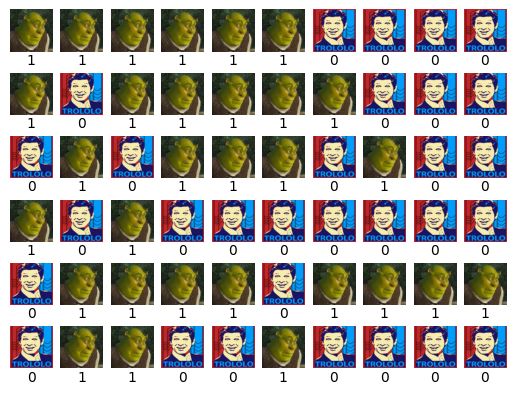

In [ ]:
print("*"*25,end=" ")
print("Unwanted Images ",end='*'*25)
show_images(dataset=outliers,labels =y[index_of_outliers], batch_no=0,no_images_per_batch=60)

************************* Clean Images after removing outliers *************************

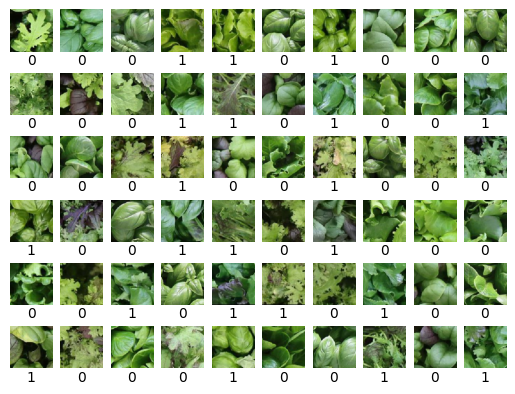

In [ ]:
print("*"*25,end=" ")
print("Clean Images after removing outliers ",end='*'*25)
show_images(dataset=x_without_outliers,labels =y_without_outliers, batch_no=0,no_images_per_batch=60)

#### 6-6 Remove Duplications

In [ ]:
# Check that our dataset has duplicate images or not

# Assuming your dataset is named 'images'
images = x_without_outliers.copy() # Replace this with your actual dataset

# Reshape the dataset to (5004, 96*96*3)
flattened_images = images.reshape((images.shape[0], -1))

# Initialize a list to store pairs of identical images
identical_pairs = []

# Iterate over all pairs of images and check for equality
for i in range(images.shape[0]):
    for j in range(i + 1, images.shape[0]): # Put images.shape[0] instead of 100
        if np.array_equal(flattened_images[i], flattened_images[j]):
            identical_pairs.append((i, j))



list_of_j = []
for i in range(len(identical_pairs)):
  list_of_j.append(identical_pairs[i][1])

array = np.array(list_of_j)
dublicated_image_index = np.unique(array)
print('These are indexes of duplicate pictures')
dublicated_image_index

These are indexes of duplicate pictures


array([ 155,  237,  295,  328,  453,  512,  526,  565,  704,  785,  859,
        957,  981, 1105, 1207, 1295, 1422, 1654, 1657, 1700, 1722, 1742,
       1772, 1806, 1820, 1853, 1891, 1900, 1995, 2074, 2118, 2120, 2133,
       2186, 2194, 2206, 2213, 2225, 2305, 2315, 2331, 2433, 2439, 2484,
       2486, 2519, 2534, 2572, 2605, 2635, 2689, 2713, 2745, 2769, 2788,
       2802, 2817, 2850, 2851, 2935, 2944, 2946, 2976, 3031, 3034, 3119,
       3123, 3143, 3262, 3267, 3279, 3290, 3381, 3388, 3471, 3472, 3480,
       3490, 3493, 3603, 3664, 3694, 3696, 3740, 3759, 3784, 3791, 3816,
       3848, 3850, 3874, 3884, 3897, 3934, 3937, 3946, 3977, 3993, 3997,
       3998, 4017, 4022, 4028, 4067, 4083, 4103, 4116, 4177, 4181, 4189,
       4199, 4233, 4272, 4282, 4304, 4321, 4322, 4324, 4360, 4365, 4371,
       4379, 4385, 4408, 4445, 4451, 4470, 4496, 4497, 4516, 4523, 4547,
       4586, 4599, 4619, 4700, 4703, 4714, 4715, 4741, 4746, 4769, 4790,
       4791, 4813, 4816, 4852, 4898, 4900, 4908, 49

In [ ]:
print("No of duplicate images is: ",dublicated_image_index.shape[0])

No of duplicate images is:  154


In [ ]:
# Remove duplicated images and their labels from our dataset

# Create a mask to select the indices to keep
mask_to_keep = np.ones(x_without_outliers.shape[0], dtype=bool)
mask_to_keep[dublicated_image_index] = False

# Create a new array excluding the specified indices
clean_x = x_without_outliers[mask_to_keep]


#
# Create a mask to select the indices to keep
mask_to_keep = np.ones(y_without_outliers.shape[0], dtype=bool)
mask_to_keep[dublicated_image_index] = False

# Create a new array excluding the specified indices
clean_y = y_without_outliers[mask_to_keep]
print("Number of images after removing outliers and duplicate images is: ",clean_y.shape[0])

Number of images after removing outliers and duplicate images is:  4850


In [ ]:
no_images = clean_x.shape[0]
no_labels = clean_y.shape[0]
_, counts = np.unique(clean_y,return_counts=True) # count occurrence of each item
no_healthy_images = counts[0]
no_unhealthy_images = counts[1]

# pass variables to a dictionary to be used as dataframe for a better show
info_table_dict = {"number_of_clean_images":no_images, "image_width": size_images[0],"image_length": size_images[1], "number_of_labels":no_labels,
                   "number_of_healthy_images":no_healthy_images,"percentage%":no_healthy_images*100/no_labels,
                   "number_of_unhealthy_images":no_unhealthy_images,"percentage %":no_unhealthy_images*100/no_labels }
print("*"*42,end=" ")
print("Our Table after Removing Outliers and Duplicate images ",end='*'*42)
info_table = pd.DataFrame(info_table_dict, index =['value'])
info_table

****************************************** Our Table after Removing Outliers and Duplicate images ******************************************

,number_of_clean_images,image_width,image_length,number_of_labels,number_of_healthy_images,percentage%,number_of_unhealthy_images,percentage %
value,4850,96,96,4850,3060,63.092784,1790,36.907216


###7- Save Clean Data

In [ ]:
# Save these variables to use for nex notebooks.
np.savez_compressed("/content/clean_plant_dataset",clean_x = clean_x, clean_y= clean_y)


cp: cannot stat '/content/clean_plant_dataset': No such file or directory


In [ ]:
# Copy it to your drive
! cp "/content/clean_plant_dataset.npz" "/content/drive/MyDrive"